In [17]:
# Libreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.arima.model import ARIMA


In [5]:
df_raw = sns.load_dataset('flights')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [6]:
df_raw.tail(20)

,year,month,passengers
124,1959,May,420
125,1959,Jun,472
126,1959,Jul,548
127,1959,Aug,559
128,1959,Sep,463
129,1959,Oct,407
130,1959,Nov,362
131,1959,Dec,405
132,1960,Jan,417
133,1960,Feb,391


In [7]:
df_interim = df_raw.copy()
df_interim['month'] = pd.to_datetime(df_interim['month'], format='%b').dt.month
df_interim['date'] = pd.to_datetime(df_interim[['year', 'month']].assign(day=1))
df_interim = df_interim.set_index('date')
ts = df_interim['passengers']

In [8]:
ts

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: passengers, Length: 144, dtype: int64

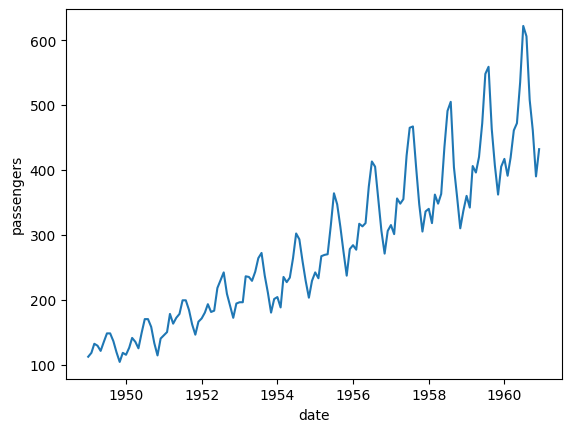

In [9]:
sns.lineplot(data=ts)
plt.show()

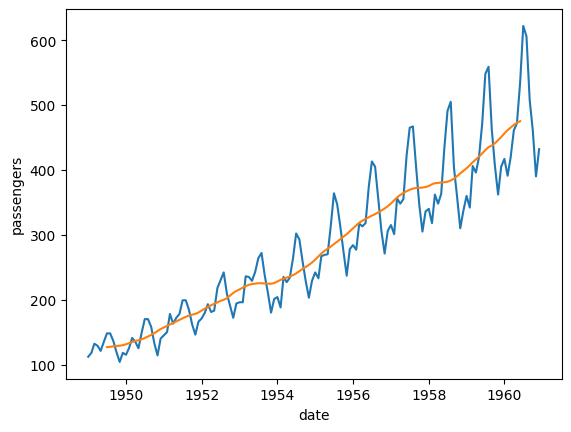

In [10]:
decomposition = seasonal_decompose(ts, period=12)
trend = decomposition.trend
sns.lineplot(ts)
sns.lineplot(trend)
plt.show()

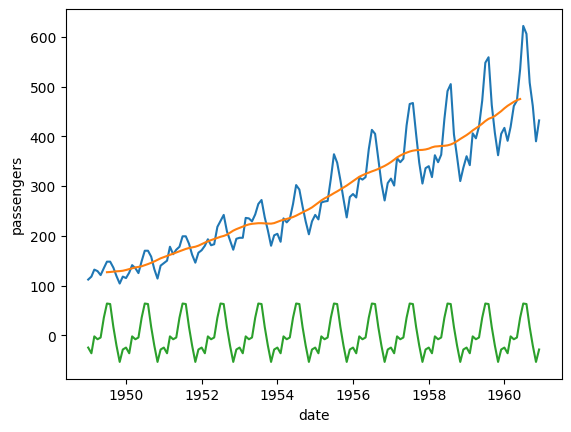

In [11]:
decomposition = seasonal_decompose(ts, period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
sns.lineplot(ts)
sns.lineplot(trend)
sns.lineplot(seasonal)
plt.show()

In [12]:
def test_stationarity(time_series):
    print("Results")
    df_test = adfuller(time_series, autolag='AIC')
    df_out = pd.Series(df_test[0:4], index=['test statistic', 'pvalue', 'lags', 'no observations'])
    for key, value in df_test[4].items():
        df_out['critical values (%s)'%key] = value
    
    return df_out

test_stationarity(ts)

Results


test statistic             0.815369
pvalue                     0.991880
lags                      13.000000
no observations          130.000000
critical values (1%)      -3.481682
critical values (5%)      -2.884042
critical values (10%)     -2.578770
dtype: float64

pvalue indica que no es estacionario

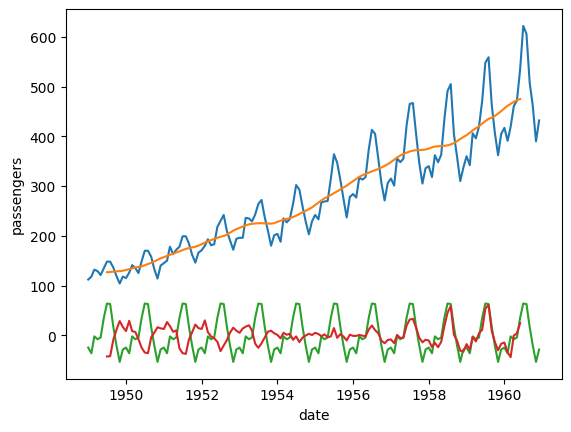

In [13]:
decomposition = seasonal_decompose(ts, period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
sns.lineplot(ts)
sns.lineplot(trend)
sns.lineplot(seasonal)
sns.lineplot(residual)
plt.show()

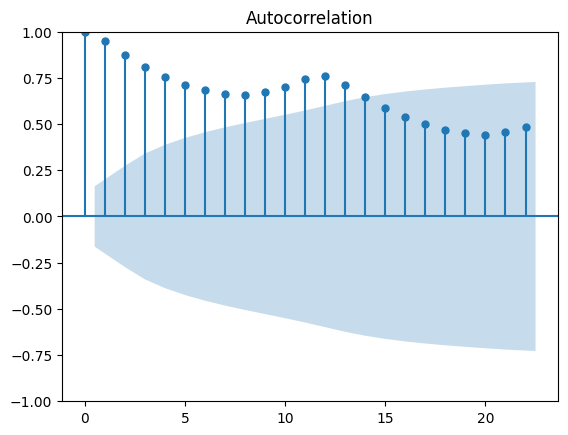

In [14]:
plot_acf(ts)
plt.show()

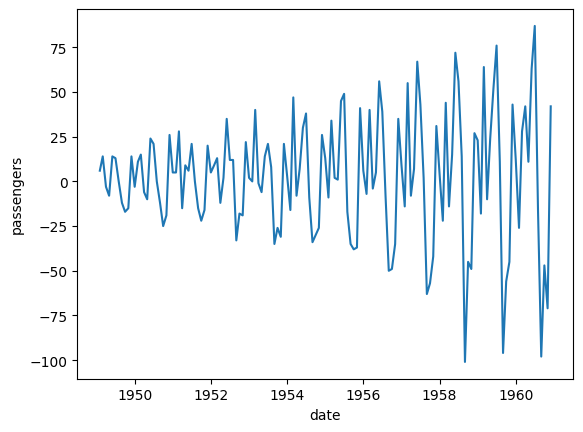

In [15]:
ts_stationary = ts.diff().dropna() # diff t+1 - t
sns.lineplot(ts_stationary)
plt.show()

la tendencia = 0 => estacionaria

In [16]:
test_stationarity(ts_stationary)

Results


test statistic            -2.829267
pvalue                     0.054213
lags                      12.000000
no observations          130.000000
critical values (1%)      -3.481682
critical values (5%)      -2.884042
critical values (10%)     -2.578770
dtype: float64

In [18]:
model = ARIMA(ts_stationary, order=(0,0,1))
model_fit = model.fit()


/workspaces/time_series/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspaces/time_series/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspaces/time_series/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [19]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  143
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -696.414
Date:                Tue, 22 Oct 2024   AIC                           1398.827
Time:                        03:29:22   BIC                           1407.716
Sample:                    02-01-1949   HQIC                          1402.439
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4220      3.735      0.648      0.517      -4.898       9.742
ma.L1          0.4012      0.077      5.202      0.000       0.250       0.552
sigma2       993.2318    107.912      9.204      0.000     781.728    1204.736
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 1.85
Prob(Q):                              0.80   Prob(JB):                         0.40
Heteroskedasticity (H):               8.06   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""